In [ ]:
R.version.string

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

In [ ]:
# print(installed.packages())

In [1]:
install.packages("keras")
install.packages("tokenizers")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’




In [2]:
library(httr)
library(tidyverse)
library(stringr)
library(dplyr)
library(keras)
library(tokenizers)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
#upload your data file
myData = read.csv("myDataSource.csv")
dim(myData)

[1] 19115     4

In [4]:
#defining the default parameters 
max_words <- 10000
maxlen <- 400
training_samples <- as.integer(0.75 * dim(myData)[1])
validation_samples <- as.integer(0.25 * dim(myData)[1])
tokenizer <- text_tokenizer(num_words = max_words) %>% fit_text_tokenizer(myData$description)
sequences <- texts_to_sequences(tokenizer, myData$description)
word_index = tokenizer$word_index
cat("Found",length(word_index), "unique tokens. \n")

#padding sequences to make them of equal length
data <- pad_sequences(sequences, maxlen = maxlen)
labels <- as.array(as.numeric(factor(myData$source)))
cat("Shape of data tensor (Num Docs, Num Words in a Doc):", dim(data), "\n")
cat('Shape of label tensor (Num Docs):', dim(labels), "\n")

Loaded Tensorflow version 2.9.2



Found 41221 unique tokens. 
Shape of data tensor (Num Docs, Num Words in a Doc): 19115 400 
Shape of label tensor (Num Docs): 19115 


In [5]:
#padding sequences to make them of equal length
data <- pad_sequences(sequences, maxlen = maxlen)
labels <- as.array(as.numeric(factor(myData$source)))
cat("Shape of data tensor (Num Docs, Num Words in a Doc):", dim(data), "\n")
cat('Shape of label tensor (Num Docs):', dim(labels), "\n")

Shape of data tensor (Num Docs, Num Words in a Doc): 19115 400 
Shape of label tensor (Num Docs): 19115 


In [6]:
unique(labels)
length(unique(labels))

[1]  3  2  5  7  1 11  4  8  6 10  9

[1] 11

In [7]:
# data[2,]

In [8]:
set.seed(123)
indices <- sample(1:nrow(data))

training_indices <- indices[1:training_samples]
validation_indices <- indices[(training_samples + 1):
(training_samples + validation_samples)]
x_train <- data[training_indices,]
y_train <- labels[training_indices]
x_val <- data[validation_indices,]
y_val <- labels[validation_indices]
y_val<- to_categorical(y_val)
y_train <- to_categorical(y_train)
dim(x_train)
dim(y_train)
dim(x_val)
dim(y_val)

[1] 14336   400

[1] 14336    12

[1] 4778  400

[1] 4778   12

In [9]:
# embedding_dim <- 100
# model_embd_100 <- keras_model_sequential() %>% 
#   layer_embedding(input_dim = max_words,
#                   input_length = maxlen,
#                   output_dim = embedding_dim) %>%
#                   layer_flatten() %>%
#                   layer_dense(units = 32, activation = "relu") %>%
#                   layer_dense(units = dim(y_train)[2], activation = "softmax")
                
# model_embd_100 %>% compile(
#   optimizer = "adam",
#   loss = "categorical_crossentropy",
#   metrics = c("accuracy")
# )

# history <- model_embd_100 %>% fit(
#   x_train, y_train,
#   epochs = 20,
#   batch_size = 256,
#   validation_data = list(x_val, y_val)
# )
# plot(history)
# results <- model_embd_100 %>% evaluate(x_val, y_val)
# results

[1] 100
     loss  accuracy 
0.8664173 0.7831729 
[1] 200


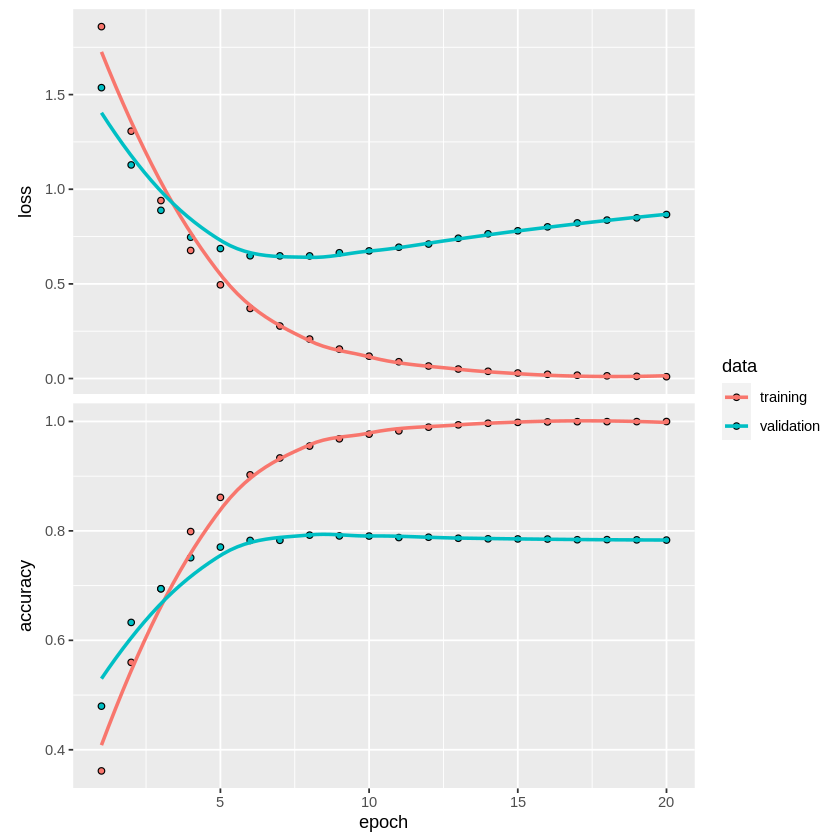

     loss  accuracy 
0.8458633 0.8013813 
[1] 300


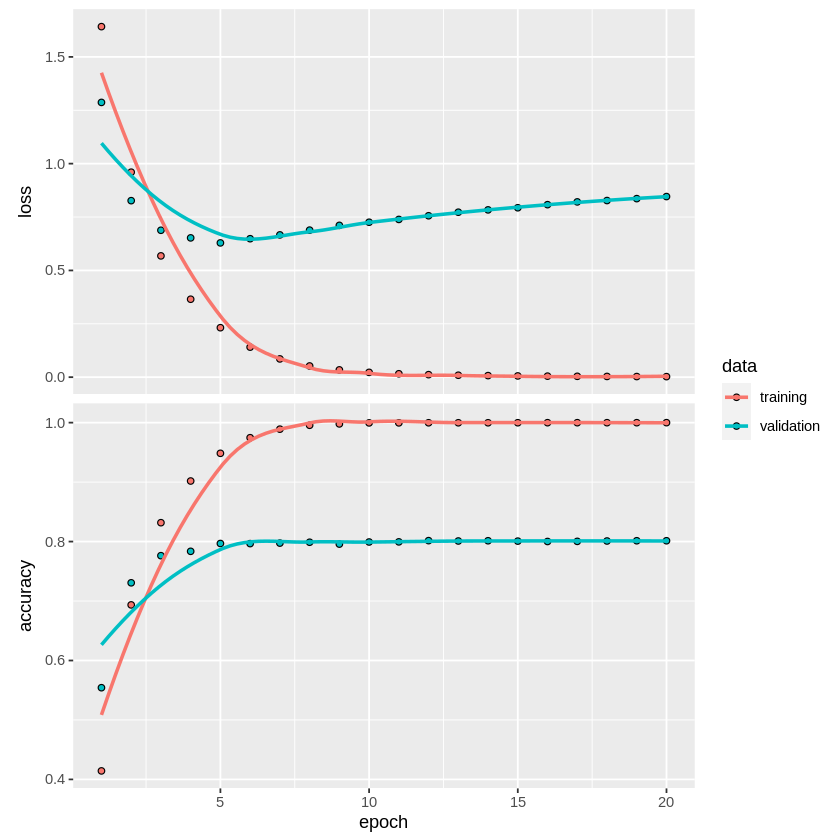

     loss  accuracy 
1.0103366 0.7714525 
[1] 400


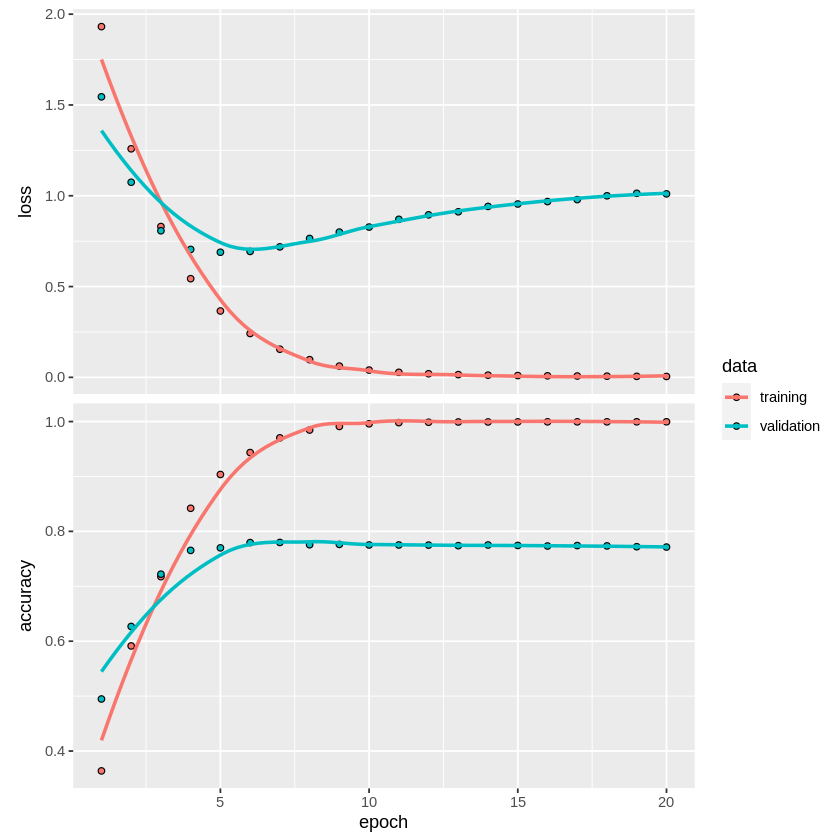

     loss  accuracy 
0.8686658 0.7902888 


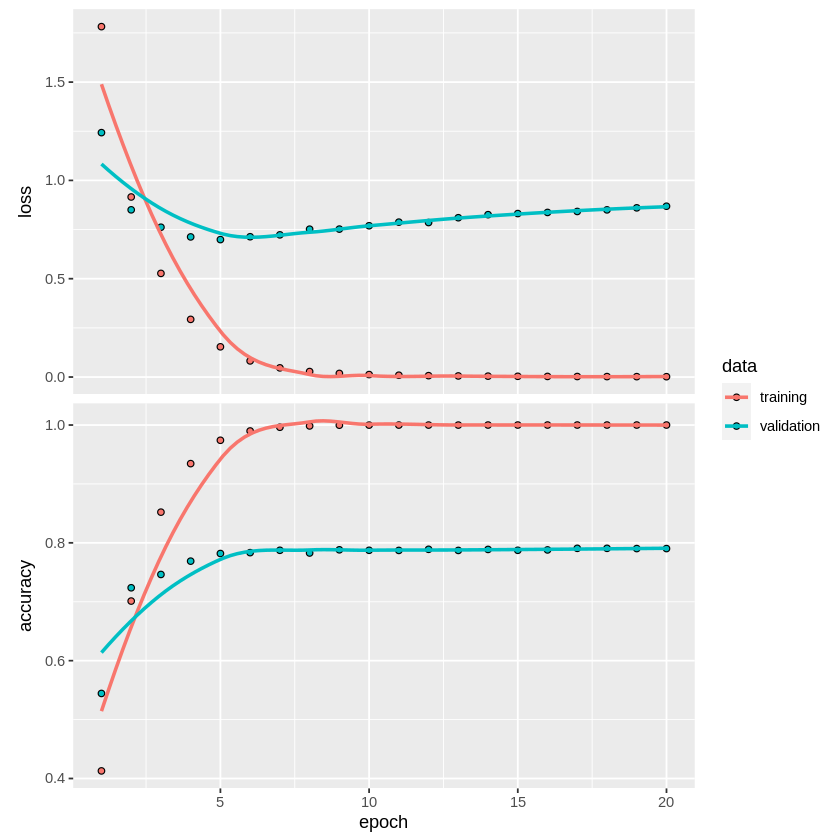

In [11]:
embedding_sizes = c(100,200,300,400)
result_list = c()
for (embedding in embedding_sizes){
    print(embedding)
    embedding_dim <- embedding
    model <- keras_model_sequential() %>% 
    layer_embedding(input_dim = max_words,
                    input_length = maxlen,
                    output_dim = embedding_dim) %>%
                    layer_flatten() %>%
                    layer_dense(units = 32, activation = "relu") %>%
                    layer_dense(units = dim(y_train)[2], activation = "softmax")
                    
    model %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

    history <- model %>% fit(
    x_train, y_train,
    epochs = 20,
    batch_size = 256,
    validation_data = list(x_val, y_val)
    )
    print(plot(history))
    results <- model %>% evaluate(x_val, y_val)
    print(results)
    result_list = append(result_list,results)
}

In [12]:
result_list

loss  accuracy      loss  accuracy      loss  accuracy      loss  accuracy 
0.8664173 0.7831729 0.8458633 0.8013813 1.0103366 0.7714525 0.8686658 0.7902888

     loss  accuracy 
2.2118287 0.4771871 


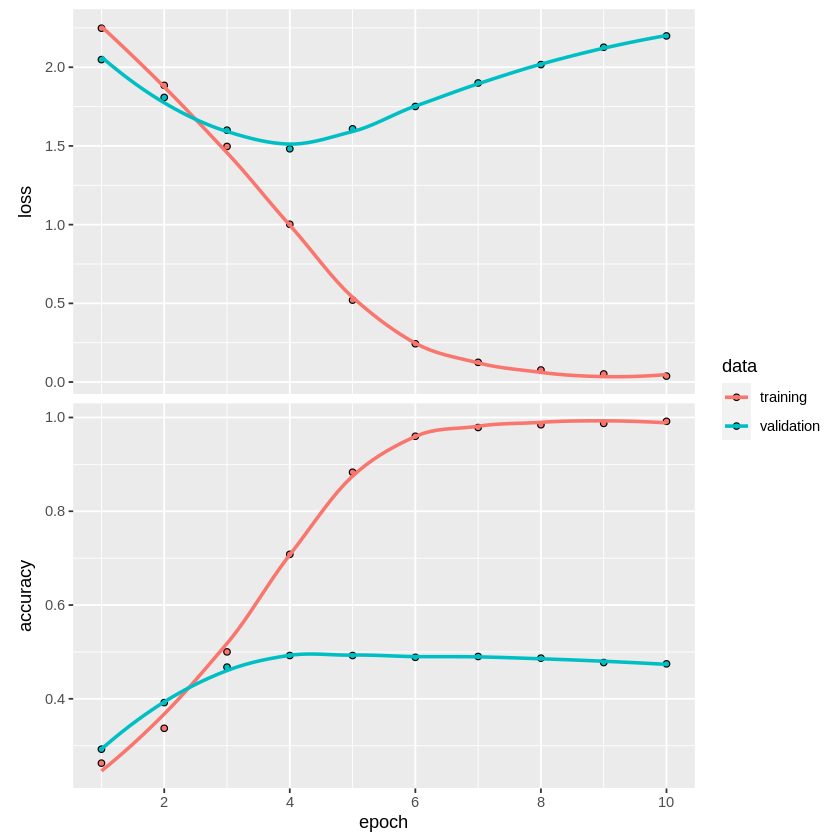

In [13]:
#rnn model
output_dim = 32
embedding_dim = 100
model_rnn <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim) %>%
    layer_simple_rnn(units = output_dim) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_rnn %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_rnn %>% fit(
    x_train, y_train,
    epochs = 10,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_rnn <- model_rnn %>% evaluate(x_val, y_val)
print(results_rnn)
result_list = append(result_list,results_rnn)

     loss  accuracy 
1.8110083 0.6167853 


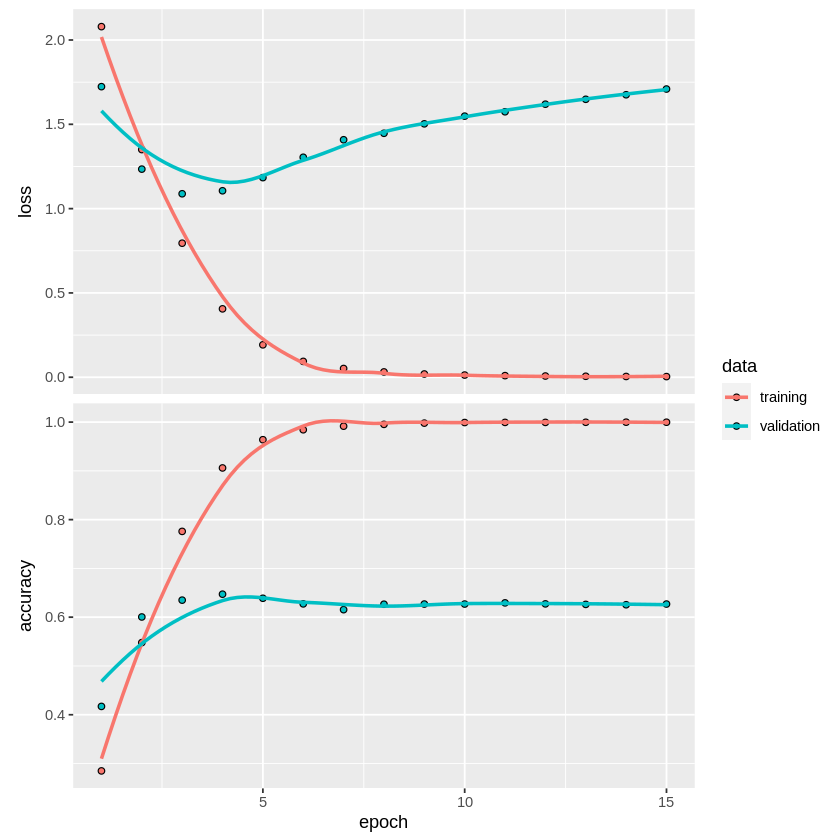

In [14]:
#multilayer RNN
output_dim = 32
embedding_dim = 100
model_mlrnn <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim) %>%
    layer_simple_rnn(units = output_dim, return_sequences = TRUE) %>%
    layer_simple_rnn(units = output_dim, return_sequences = TRUE) %>%
    layer_simple_rnn(units = output_dim, return_sequences = TRUE) %>%
    layer_simple_rnn(units = output_dim) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_mlrnn %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_mlrnn %>% fit(
    x_train, y_train,
    epochs = 15,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_mlrnn <- model_mlrnn %>% evaluate(x_val, y_val)
print(results_mlrnn)
result_list = append(result_list,results_mlrnn)

loss  accuracy 
1.3787525 0.7247803

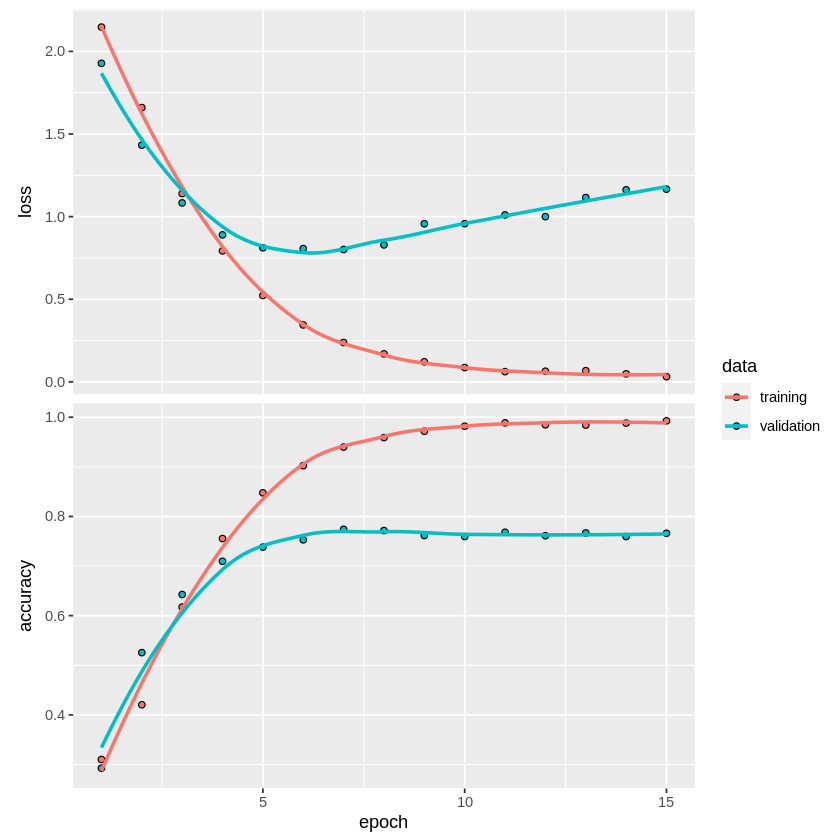

In [15]:
#LSTM
output_dim = 32
embedding_dim = 100
model_lstm <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim) %>%
    layer_lstm(units = output_dim) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_lstm %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_lstm %>% fit(
    x_train, y_train,
    epochs = 15,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_lstm <- model_lstm %>% evaluate(x_val, y_val)
results_lstm
result_list = append(result_list,results_lstm)

loss  accuracy 
1.6496844 0.7281289

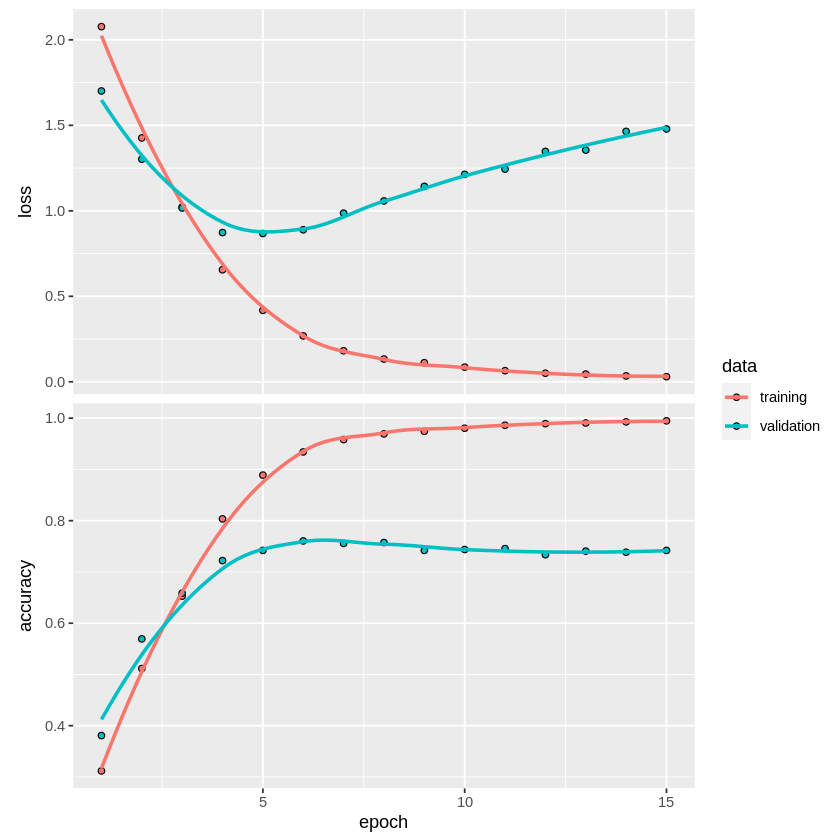

In [16]:
#Bi-Directional LSTM
output_dim = 32
embedding_dim = 100
model_bilstm <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim) %>%
    bidirectional(layer_lstm(units = output_dim)) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_bilstm %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_bilstm %>% fit(
    x_train, y_train,
    epochs = 15,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_bilstm <- model_bilstm %>% evaluate(x_val, y_val)
results_bilstm
result_list = append(result_list,results_bilstm)

loss  accuracy 
1.7582350 0.6883633

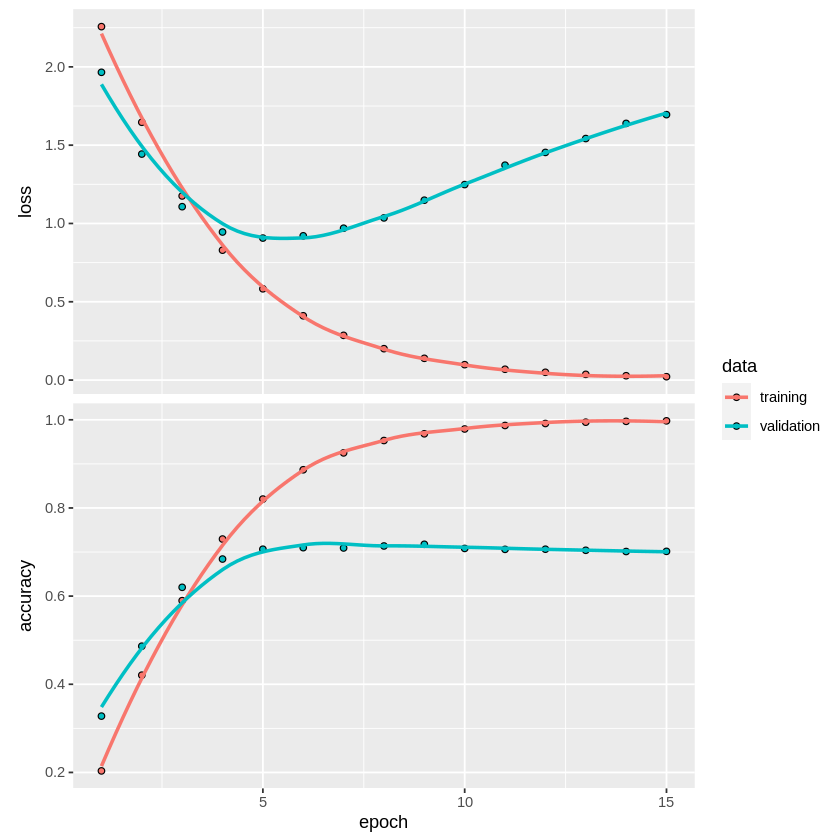

In [44]:
#1d Convo
filter_size = 32
embedding_dim = 128
model_1dcnn <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim, input_length = maxlen) %>%
    layer_conv_1d(filters = 32, kernel_size = 7, activation = "relu") %>%
    layer_max_pooling_1d(pool_size = 5) %>%
    layer_conv_1d(filters = 32, kernel_size = 7, activation = "relu") %>%
    layer_global_max_pooling_1d() %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_1dcnn %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_1dcnn %>% fit(
    x_train, y_train,
    epochs = 15,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_1dcnn <- model_1dcnn %>% evaluate(x_val, y_val)
results_1dcnn
result_list = append(result_list,results_1dcnn)

loss  accuracy 
1.7615317 0.6758057

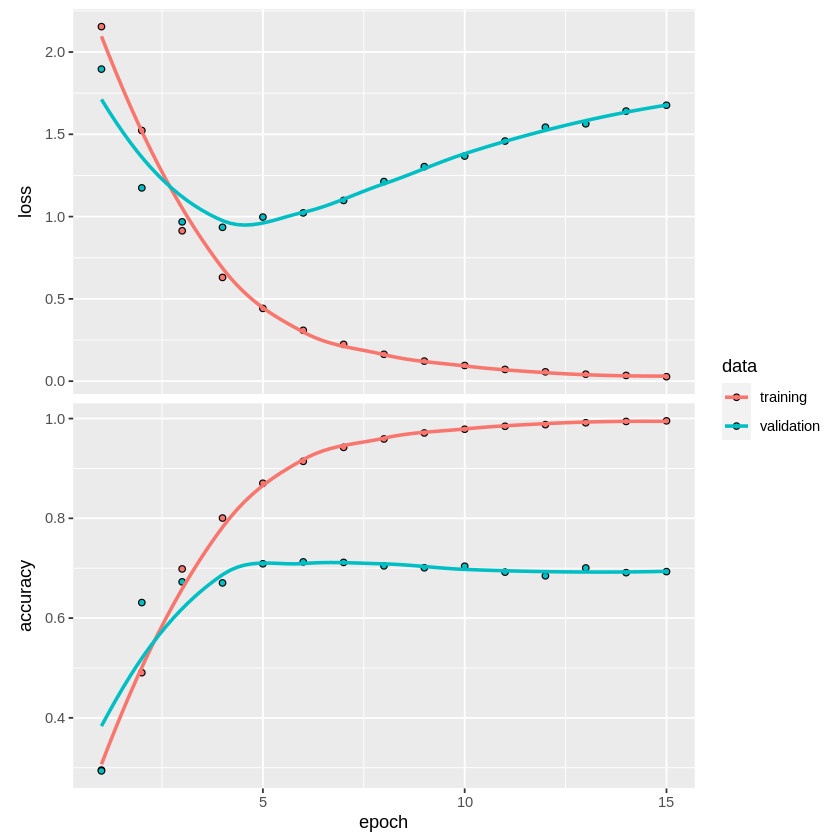

In [47]:
#1d Convo with bi-lstm
filter_size = 32
embedding_dim = 128
model_bilstm_1dcnn <- keras_model_sequential() %>%
    layer_embedding(input_dim = max_words, output_dim = embedding_dim, input_length = maxlen) %>%
    layer_conv_1d(filters = 32, kernel_size = 5, activation = "relu", input_shape = list(NULL, dim(data)[[-1]])) %>%
    layer_max_pooling_1d(pool_size = 3) %>%
    layer_conv_1d(filters = 32, kernel_size = 5, activation = "relu") %>%
    bidirectional(layer_lstm(units = 32)) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = dim(y_train)[2], activation = "softmax")

model_bilstm_1dcnn %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
    )

history <- model_bilstm_1dcnn %>% fit(
    x_train, y_train,
    epochs = 15,
    batch_size = 256,
    validation_split = 0.2
)
plot(history)
results_bilstm_1dcnn <- model_bilstm_1dcnn %>% evaluate(x_val, y_val)
results_bilstm_1dcnn
result_list = append(result_list,results_bilstm_1dcnn)

In [48]:
#to do
#write code to dump the result dataframe to csv
#read the result csv file and then do the graphical representation/comparison of results
models = c('NN_embd_100','NN_embd_200','NN_embd_300','NN_embd_400','RNN','Mulilayer RNN','LSTM','BI-LSTM','1d-CNN','1d-CNN-BiLSTM')
loss = c()
accuracy = c()
i=1
for (item in result_list){
        if (i%%2==1){
            loss = append(loss,item)
        }
        else{
            accuracy = append(accuracy,item)
        }
        i=i+1
    }

# print(loss)
# print(accuracy)
result_df = data.frame(models = models, loss = loss, accuracy = accuracy)
write.csv(result_df,'results.csv')